# **Import Libraries**

In [1]:
import pandas as pd
import re
import nltk
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import all_estimators  # Import all_estimators module to get a list of classifiers
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download NLTK stopwords if you haven't already
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Load Dataset**

In [3]:
df = pd.read_csv('/content/drive/MyDrive/vaccination_tweets.csv')

In [4]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [5]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [6]:
df = df[['text']]

In [7]:
df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [8]:
df.shape

(11020, 1)

In [9]:
df.drop_duplicates(inplace = True)

In [10]:
df.shape

(11013, 1)

In [11]:
df.isnull().sum()

text    0
dtype: int64

# **Data Processing**

**Removing Special Characters, Tokenization, Stopwords and Lowercasing**

In [12]:
def data_processing(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Remove retweets
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'https\S+|www\S+https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = text.lower()

    text_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_text = [w for w in text_tokens if not w in stop_words]

    return ' '.join(filtered_text)

In [13]:
df.text = df['text'].apply(data_processing)

In [14]:
df.shape

(11013, 1)

In [15]:
df = df.drop_duplicates('text')

In [16]:
df.shape

(10481, 1)

**Stemming**

In [17]:
stemmer = PorterStemmer()

In [18]:
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [19]:
df['text'] = df['text'].apply(lambda x: stemming(x))

In [20]:
df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine whereareallthesickpeople ...


## **Polarity**

In [21]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [22]:
df['polarity'] = df['text'].apply(polarity)

In [23]:
df.head()

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.0
1,world wrong side history year hopefully bigges...,-0.5
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0
3,facts immutable senator even youre ethically s...,0.1
4,explain need vaccine whereareallthesickpeople ...,0.0


# **Sentiments**

In [24]:
def sentiment(label):
    if label < 0:
        return 'Negative'
    elif label > 0:
        return 'Positve'
    elif label == 0:
        return 'Neutral'

In [25]:
df['sentiment'] = df['polarity'].apply(sentiment)

In [26]:
df.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positve
4,explain need vaccine whereareallthesickpeople ...,0.0,Neutral


# **Visualize Sentiment Distribution**

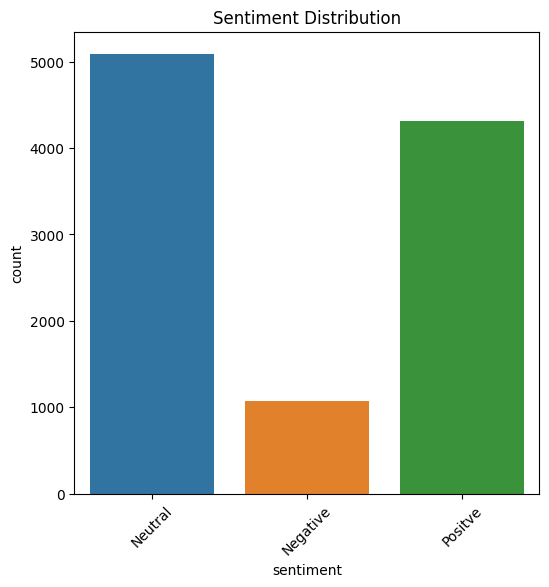

In [27]:
sentiment_counts = df['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 6))
sns.countplot(x='sentiment', data = df)
plt.title('Sentiment Distribution')
plt.xticks(rotation=45)
plt.show()

# **Visualize Pie Graph**

Text(0.5, 1.0, 'Sentiment Distribution')

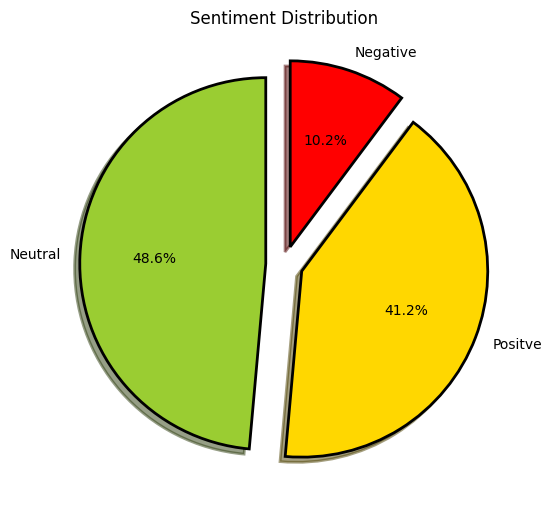

In [28]:
fig = plt.figure(figsize=(6,7))
colors = ('yellowgreen', 'gold', 'red')
wp = {'linewidth': 2, 'edgecolor': 'black'}
tags = df['sentiment'].value_counts()
explode = (0.1, 0.1, 0.1)
tags.plot(kind = 'pie', autopct = '%1.1f%%', shadow = True, colors = colors, startangle = 90,
          wedgeprops = wp, explode = explode, label = '')
plt.title("Sentiment Distribution")

# **Create a word cloud of the entire text**

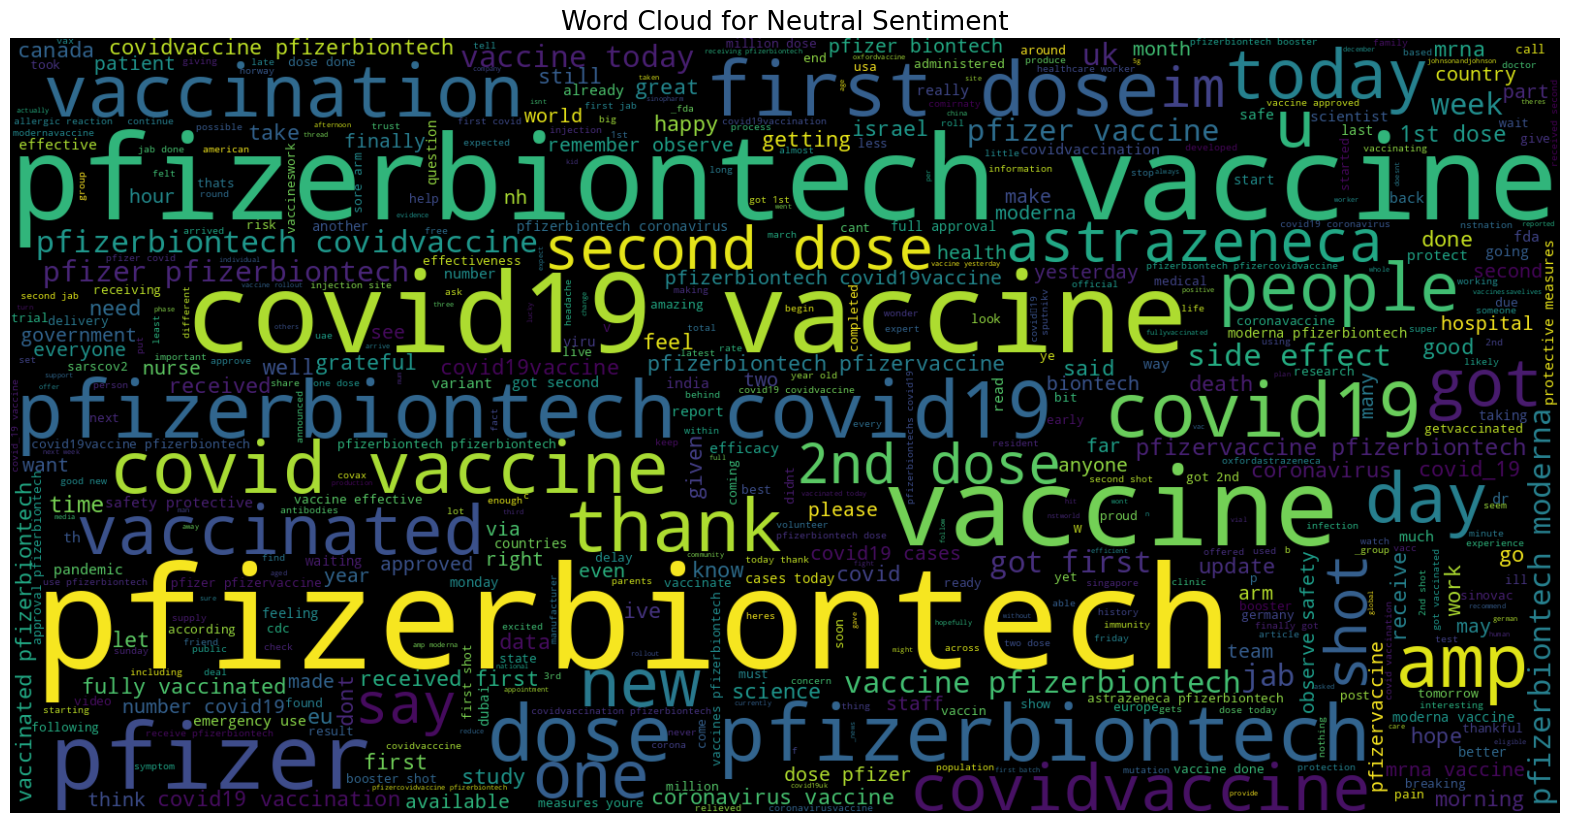

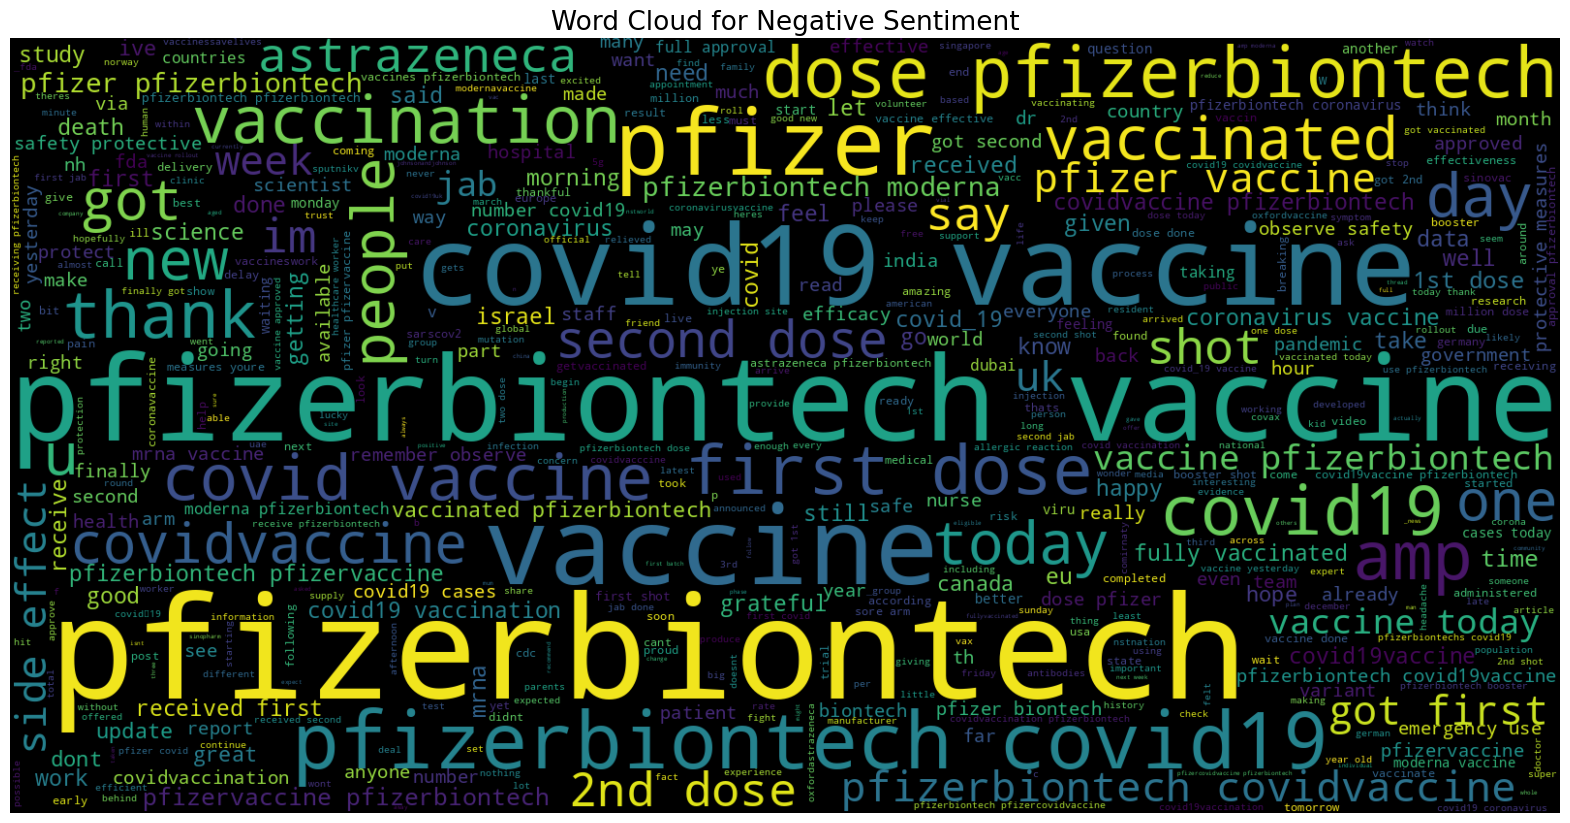

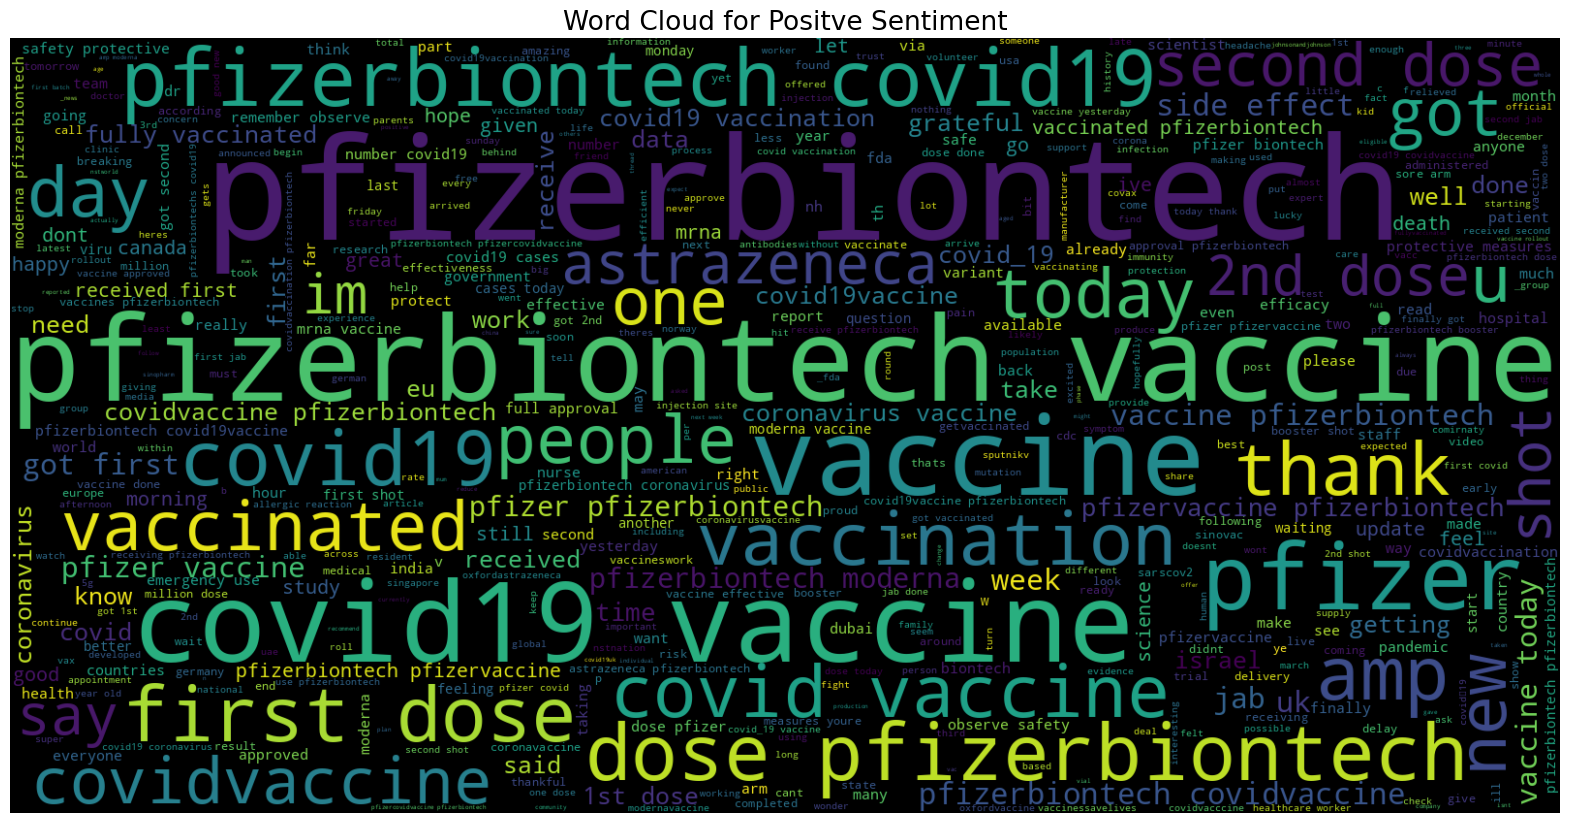

In [29]:
sentiments = df['sentiment'].unique()

for sentiment in sentiments:
    text = ' '.join(df['text'])
    plt.figure(figsize=(20, 15), facecolor = None)
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment', fontsize=19)
    plt.axis('off')
    plt.show()

# **Visualize Text Length Distribution by Sentiment**

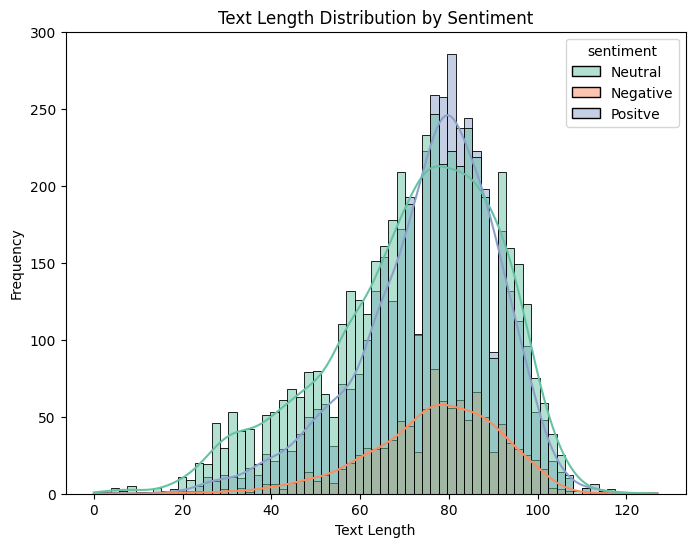

In [30]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x=df['text'].str.len(), hue='sentiment', kde=True, palette='Set2')
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# **Word frequency analysis**

In [31]:
word_freq = Counter(text.split())
common_words = word_freq.most_common(20)  # Get the 20 most common words
print('Top 20 Most Common Words:')
for word, freq in common_words:
    print(f'{word}: {freq}')

Top 20 Most Common Words:
pfizerbiontech: 6005
vaccine: 4101
covid19: 2306
dose: 1433
pfizer: 1301
first: 1161
today: 798
got: 784
vaccines: 735
vaccinated: 728
covidvaccine: 701
covid: 697
vaccination: 590
get: 557
second: 550
amp: 473
pfizervaccine: 461
moderna: 442
2nd: 432
people: 431


# **Convert text into vector**

**TF-IDF Vectorization**

In [32]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# **Split the dataset into training and testing sets**

In [33]:
X = tfidf_matrix
y = df['sentiment']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Explore and train all available classification estimators**

In [46]:
estimators = all_estimators(type_filter='classifier')
model_name = []
model_accuracy = []
model_precision = []
model_recall = []
model_f1 = []
for name, get_model in estimators:
    try:
        model = get_model()
        model.fit(X_train,y_train)
        pred_y = model.predict(X_test)
        model_accuracy.append(accuracy_score(y_test, pred_y))
        model_precision.append(precision_score(y_test, pred_y, average=None))
        model_recall.append(recall_score(y_test, pred_y, average=None))
        model_f1.append(f1_score(y_test, pred_y, average=None))

        model_name.append(name)

    except Exception as e:
        print('Error to import', name)
        print(e)

Error to import CategoricalNB
A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
Error to import ClassifierChain
_BaseChain.__init__() missing 1 required positional argument: 'base_estimator'
Error to import GaussianNB
A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
Error to import GaussianProcessClassifier
A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
Error to import HistGradientBoostingClassifier
A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
Error to import LabelPropagation
A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
Error to import LabelSpreading
A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
Error to import LinearDiscriminantAna

In [47]:
results=pd.DataFrame({"Model Name": model_name , "Accuracy": model_accuracy, "Precision": model_precision, "Recall": model_recall, "F1_score": model_f1})

results

,Model Name,Accuracy,Precision,Recall,F1_score
0,AdaBoostClassifier,0.801144,"[0.8409090909090909, 0.7338483146067416, 0.968...","[0.5045454545454545, 1.0, 0.6298076923076923]","[0.6306818181818182, 0.8464965573106521, 0.763..."
1,BaggingClassifier,0.864092,"[0.6838709677419355, 0.8515021459227468, 0.918...","[0.4818181818181818, 0.9492822966507177, 0.858...","[0.5653333333333334, 0.897737556561086, 0.8875..."
2,BernoulliNB,0.815928,"[0.4946236559139785, 0.8578110383536015, 0.833...","[0.41818181818181815, 0.877511961722488, 0.84375]","[0.4532019704433497, 0.8675496688741723, 0.838..."
3,CalibratedClassifierCV,0.883643,"[0.8389830508474576, 0.8619528619528619, 0.922...","[0.45, 0.9799043062200957, 0.8774038461538461]","[0.5857988165680474, 0.9171518137035378, 0.899..."
4,ComplementNB,0.778732,"[0.4349593495934959, 0.8401639344262295, 0.806...","[0.4863636363636364, 0.784688995215311, 0.8485...","[0.45922746781115875, 0.8114794656110836, 0.82..."
5,DecisionTreeClassifier,0.822604,"[0.5583756345177665, 0.8443830570902394, 0.857...","[0.5, 0.877511961722488, 0.8389423076923077]","[0.52757793764988, 0.8606288127639606, 0.84811..."
6,DummyClassifier,0.498331,"[0.0, 0.4983309489747258, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.6651814131126671, 0.0]"
7,ExtraTreeClassifier,0.757272,"[0.4881516587677725, 0.7981220657276995, 0.773...","[0.4681818181818182, 0.8133971291866029, 0.763...","[0.4779582366589327, 0.8056872037914692, 0.768..."
8,ExtraTreesClassifier,0.888412,"[0.8484848484848485, 0.8674596431605778, 0.926...","[0.509090909090909, 0.9770334928229665, 0.8774...","[0.6363636363636364, 0.918991899189919, 0.9012..."
9,GradientBoostingClassifier,0.827849,"[0.875, 0.7603787327021122, 0.9693548387096774]","[0.41363636363636364, 0.999043062200957, 0.722...","[0.5617283950617284, 0.8635235732009925, 0.827..."


# **Classifier of Max. Accuracy**

In [55]:
results[results['Accuracy'] == results['Accuracy'].max()]

,Model Name,Accuracy,Precision,Recall,F1_score
22,SGDClassifier,0.894134,"[0.8916666666666667, 0.8605809128630706, 0.946...","[0.4863636363636364, 0.9923444976076555, 0.878...","[0.6294117647058823, 0.9217777777777778, 0.911..."


In [57]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()

# Fit the classifier to the training data
sgd.fit(X_train, y_train)

SGDClassifier()

In [58]:
y_pred = sgd.predict(X_test)

In [59]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# **Evaluate and Save the Model**

In [68]:
# Print the evaluation metrics and classifier name
print(f'Classifier: SGDClassifier')
print(f'Accuracy: {accuracy * 100 :.2f} %')
print(f'Precision: {precision * 100:.2f} %')
print(f'Recall: {recall * 100:.2f} %')
print(f'F1-score: {f1 * 100:.2f} %')

print("---------------------------------------------------")
# Save the trained model to a file
model_filename = f'SGDClassifier_sentiment_model.joblib'
joblib.dump(sgd, model_filename)
print(f'Saved model as {model_filename}')
print("---------------------------------------------------")

Classifier: SGDClassifier
Accuracy: 89.51 %
Precision: 89.95 %
Recall: 89.51 %
F1-score: 88.79 %
---------------------------------------------------
Saved model as SGDClassifier_sentiment_model.joblib
---------------------------------------------------
